## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2021-07-12 02:36:22--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.102, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bot6voeth2jr09b4dc34k2iq00366kk2/1626057375000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2021-07-12 02:36:25--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bot6voeth2jr09b4dc34k2iq00366kk2/1626057375000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|108.17

### Preprocessing

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
number_songs=250
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:number_songs]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


### Create Sequences and Labels

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

#Build the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 20s 8ms/step - loss: 5.9789 - accuracy: 0.0468
Epoch 2/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.6685 - accuracy: 0.0518
Epoch 3/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.4787 - accuracy: 0.0673
Epoch 4/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.3335 - accuracy: 0.0834
Epoch 5/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.1849 - accuracy: 0.1070
Epoch 6/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.0338 - accuracy: 0.1299
Epoch 7/100
1480/1480 [==============================] - 11s 8ms/step - loss: 4.9024 - accuracy: 0.1418
Epoch 8/100
1480/1480 [==============================] - 11s 8ms/step - loss: 4.7819 - accuracy: 0.1514
Epoch 9/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.6761 - accuracy: 0.1616
Epoch 10/100
1480/1480 [==============================] - 11s 8m

### View the Training Graph

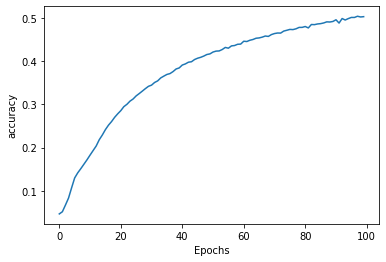

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate better lyrics!

This time around, we should be able to get a more interesting output with less repetition.

In [8]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills and know that you can be able on your sweet little money more no worries paper away it died you think was a boomaboomerang is helping park place fans promise thunder doll feeling sensation watched bars ship goin test to buy rockin head meets chat ahead part tropical tiger other minute tropical doctor doctor doctor doctor doctor doctor doctor doctor city i followed longer baby wont do honey i could do i do i do i do i do i do i do i have weave like to sing hardly gave unreal i am the tiger day when i cant


### Varying the Possible Outputs

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output? 

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [9]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

12


In [10]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills on me the fire in the took and with you if you closed the nights i can get anymore there aint all ill leave me myself sure what i had a little feelings away from loving too find sidewalks melody baby enough up slowly just nothing life gimme the same doll cries hid travel bet yellow tail chasing teacher supernatural diamond image explain farm fireplace absentminded ad feeds share four played shut road temperature tropical loveland cherry sensible stream famous bars misery happiest message beams ad melt tropical promise kids joke restless famous doll restless restless farm cover class looked


#Model with multiple LSTM


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(30)))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(total_words*2, activation='sigmoid'))
model.add(Dense(total_words, activation='softmax'))

earlyStopping = EarlyStopping(patience=10)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Total_words = 2000
#max_sequence_len = 20


ValueError: ignored

In [28]:
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
1480/1480 [==============================] - 13s 8ms/step - loss: 6.1220 - accuracy: 0.0457
Epoch 2/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0241 - accuracy: 0.0469
Epoch 3/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0157 - accuracy: 0.0469
Epoch 4/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0101 - accuracy: 0.0469
Epoch 5/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0078 - accuracy: 0.0469
Epoch 6/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0066 - accuracy: 0.0469
Epoch 7/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0062 - accuracy: 0.0469
Epoch 8/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0053 - accuracy: 0.0469
Epoch 9/200
1480/1480 [==============================] - 12s 8ms/step - loss: 6.0051 - accuracy: 0.0469
Epoch 10/200
1480/1480 [==============================] - 12s 8m

KeyboardInterrupt: ignored

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 64)            128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 2000)              82000     
Total params: 223,600
Trainable params: 223,600
Non-trainable params: 0
_________________________________________________________________
